# Import Libraries

In [1]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 15.9 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc

warnings.filterwarnings("ignore")

from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, classification_report

import xgboost as xgb
import catboost as cb
import lightgbm as lgb

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

def import_data(file, **kwargs):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True, **kwargs)
    df = reduce_mem_usage(df)
    return df

# Import Data

In [4]:
train = import_data("/content/drive/MyDrive/Colab Notebooks/kaggle/insurance_selling/datasets/train.csv", index_col = "id", engine="pyarrow")

Memory usage of dataframe is 1053.30 MB
Memory usage after optimization is: 274.30 MB
Decreased by 74.0%


In [5]:
test = import_data("/content/drive/MyDrive/Colab Notebooks/kaggle/insurance_selling/datasets/test.csv", index_col = "id", engine="pyarrow")

Memory usage of dataframe is 643.68 MB
Memory usage after optimization is: 175.55 MB
Decreased by 72.7%


In [6]:
train["Region_Code"] = train["Region_Code"].astype(np.int8)
test["Region_Code"] = test["Region_Code"].astype(np.int8)

train["Policy_Sales_Channel"] = train["Policy_Sales_Channel"].astype(np.int16)
test["Policy_Sales_Channel"] = test["Policy_Sales_Channel"].astype(np.int16)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11504798 entries, 0 to 11504797
Data columns (total 11 columns):
 #   Column                Dtype   
---  ------                -----   
 0   Gender                category
 1   Age                   int8    
 2   Driving_License       int8    
 3   Region_Code           int8    
 4   Previously_Insured    int8    
 5   Vehicle_Age           category
 6   Vehicle_Damage        category
 7   Annual_Premium        float32 
 8   Policy_Sales_Channel  int16   
 9   Vintage               int16   
 10  Response              int8    
dtypes: category(3), float32(1), int16(2), int8(5)
memory usage: 263.3 MB


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7669866 entries, 11504798 to 19174663
Data columns (total 10 columns):
 #   Column                Dtype   
---  ------                -----   
 0   Gender                category
 1   Age                   int8    
 2   Driving_License       int8    
 3   Region_Code           int8    
 4   Previously_Insured    int8    
 5   Vehicle_Age           category
 6   Vehicle_Damage        category
 7   Annual_Premium        float32 
 8   Policy_Sales_Channel  int16   
 9   Vintage               int16   
dtypes: category(3), float32(1), int16(2), int8(4)
memory usage: 168.2 MB


In [8]:
target = "Response"

In [10]:
initial_features = test.columns.to_list()
print(initial_features)

['Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']


In [11]:
categorical_features = [col for col in initial_features if pd.concat([train[col], test[col]]).nunique() < 10]

print(categorical_features)

['Gender', 'Driving_License', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage']


In [12]:
numerical_features = list(set(initial_features) - set(categorical_features))

print(numerical_features)

['Age', 'Vintage', 'Policy_Sales_Channel', 'Region_Code', 'Annual_Premium']


# Feature Distribution

In [13]:
train[categorical_features] = train[categorical_features].astype("category")
test[categorical_features] = test[categorical_features].astype("category")

## Statistical Summary of Numeric Features

In [14]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,11504798.0,38.383563,14.993459,20.0,24.0,36.0,49.0,85.0
Region_Code,11504798.0,26.418690,12.991590,0.0,15.0,28.0,35.0,52.0
Annual_Premium,11504798.0,30461.359375,16454.744141,2630.0,25277.0,31824.0,39451.0,540165.0
Policy_Sales_Channel,11504798.0,112.425442,54.035708,1.0,29.0,151.0,152.0,163.0
Vintage,11504798.0,163.897744,79.979531,10.0,99.0,166.0,232.0,299.0
Response,11504798.0,0.122997,0.328434,0.0,0.0,0.0,0.0,1.0


In [15]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,7669866.0,38.391369,14.999507,20.0,24.0,36.0,49.0,85.0
Region_Code,7669866.0,26.426614,12.994326,0.0,15.0,28.0,35.0,52.0
Annual_Premium,7669866.0,30465.523438,16445.865234,2630.0,25280.0,31827.0,39460.0,540165.0
Policy_Sales_Channel,7669866.0,112.364992,54.073585,1.0,29.0,151.0,152.0,163.0
Vintage,7669866.0,163.899577,79.984449,10.0,99.0,166.0,232.0,299.0


## Plots

### Categorical Features

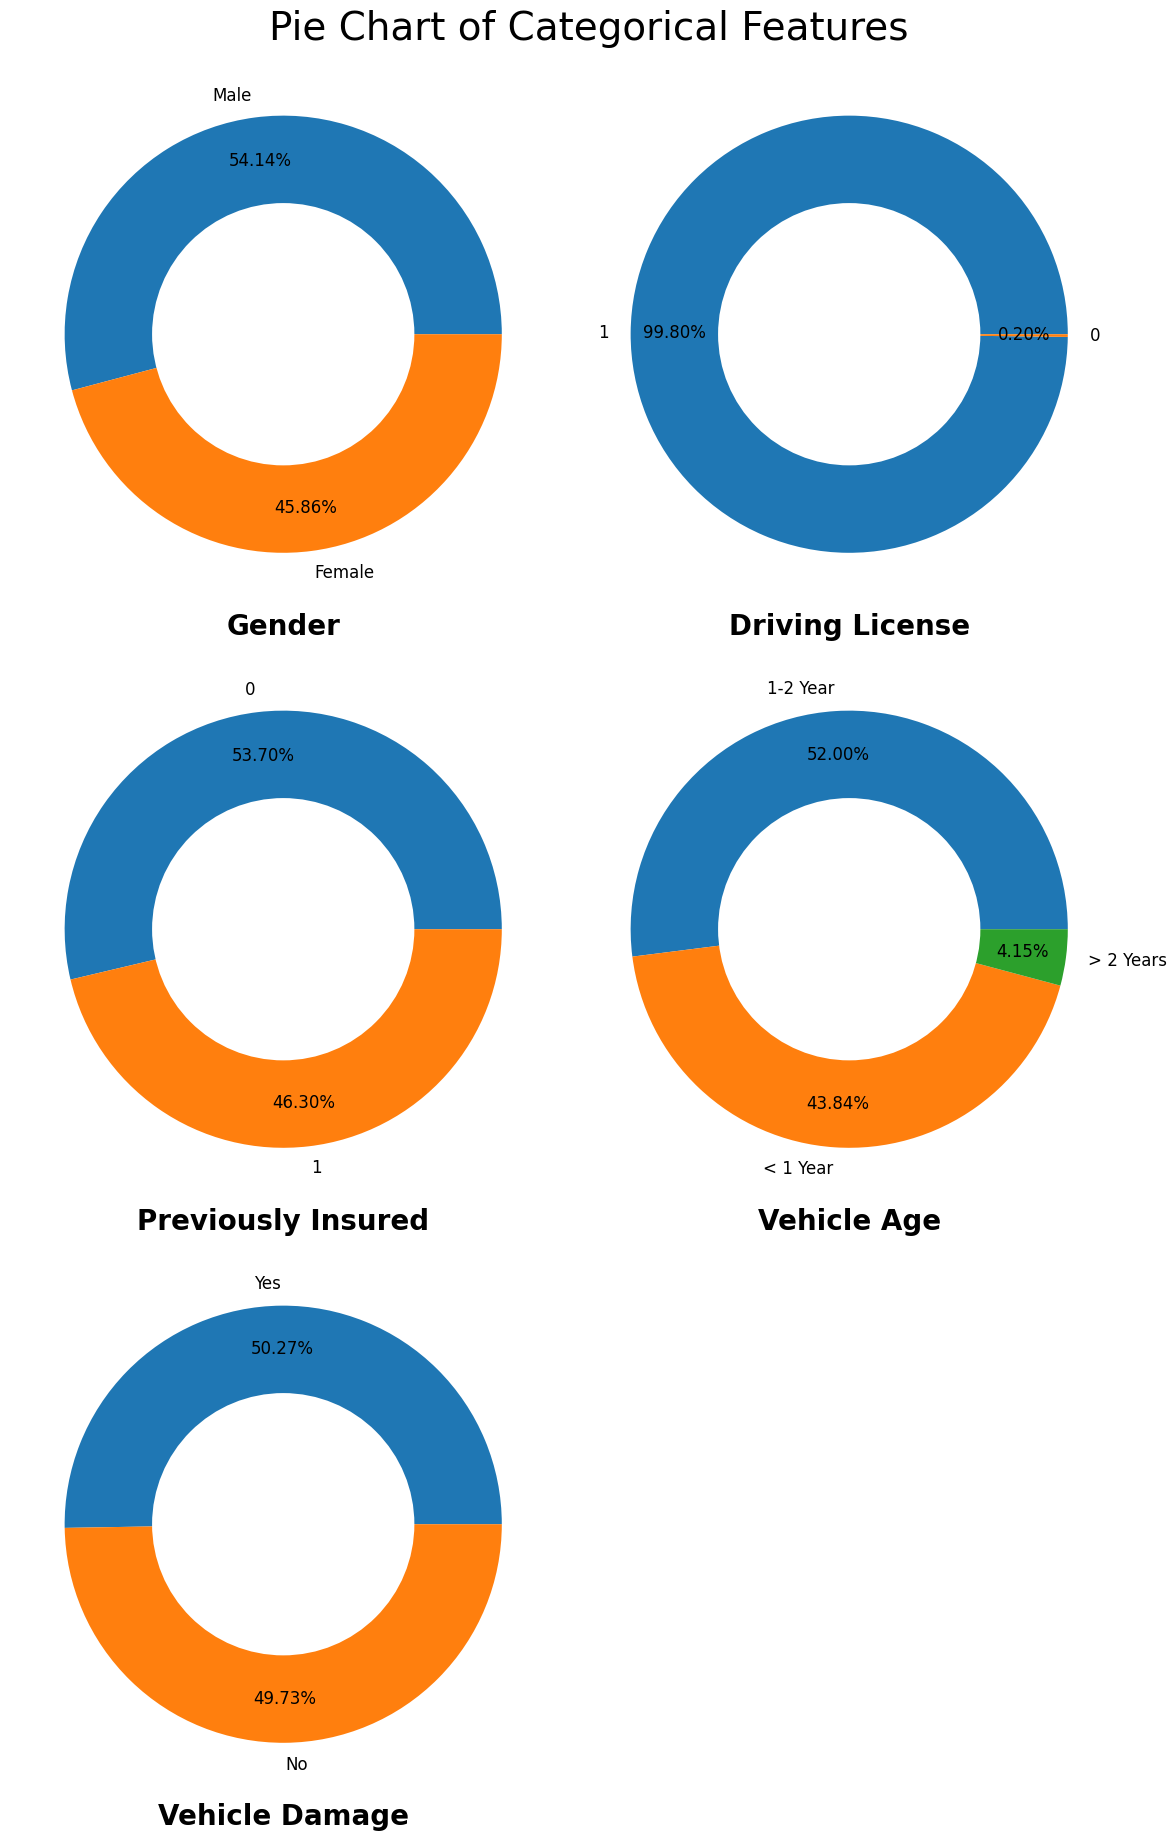

In [16]:
plt.figure(figsize=(12, 18))

for i, col in enumerate(categorical_features):
    plt.subplot(3, 2, i+1)
    train[col].value_counts().plot(kind='pie',autopct='%.2f%%',pctdistance=0.8,fontsize=12)
    plt.gca().add_artist(plt.Circle((0,0),radius=0.6,fc='white'))
    plt.xlabel(' '.join(col.split('_')), weight='bold', size=20)
    plt.ylabel("")

plt.tight_layout()
plt.suptitle("Pie Chart of Categorical Features", size=28, y=1.02)
plt.show()

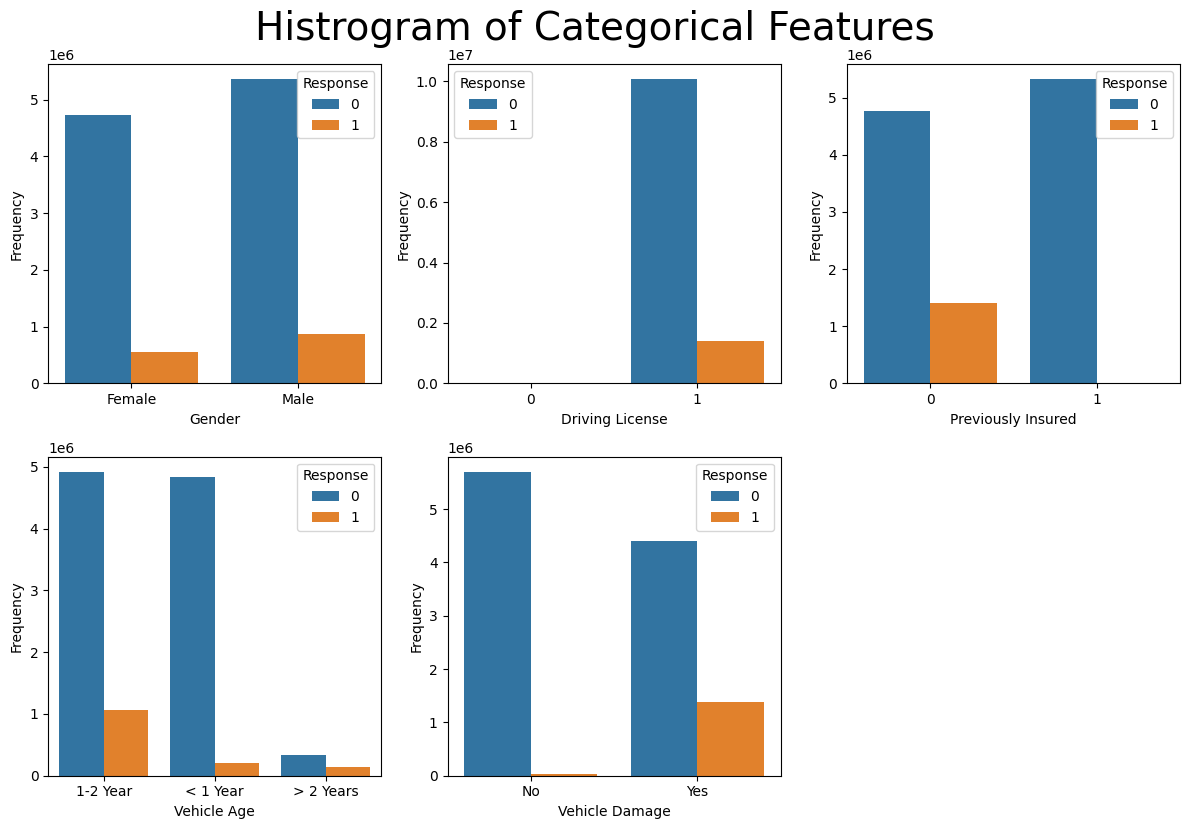

In [17]:
plt.figure(figsize=(12, 8))

for i, col in enumerate(categorical_features):
    plt.subplot(2, 3, i+1)
    sns.countplot(x=train[col], hue=train[target])
    plt.xlabel(' '.join(col.split('_')))
    plt.ylabel("Frequency")

plt.tight_layout()
plt.suptitle("Histrogram of Categorical Features", size=28, y=1.03)
plt.show()

### Numerical Features

In [18]:
# Dataset이 크기 때문에 5%만 사용하여 numerical feature의 분포를 확인함
train_sampled = train.sample(frac=0.05)

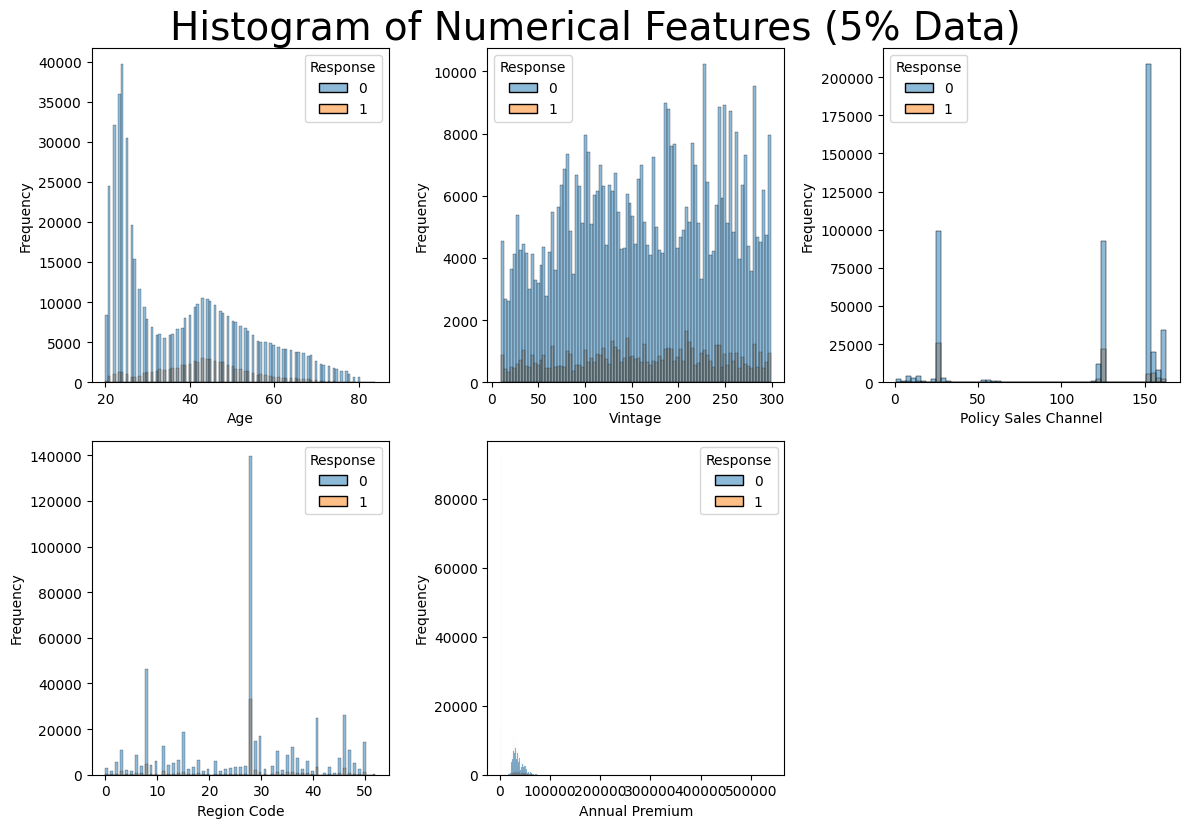

In [19]:
plt.figure(figsize=(12, 8))

for i, col in enumerate(numerical_features):
    plt.subplot(2, 3, i+1)
    sns.histplot(data=train_sampled, x=col, hue=target)
    plt.xlabel(' '.join(col.split('_')))
    plt.ylabel("Frequency")

plt.tight_layout()
plt.suptitle("Histogram of Numerical Features (5% Data)", size=28, y=1.03)
plt.show()

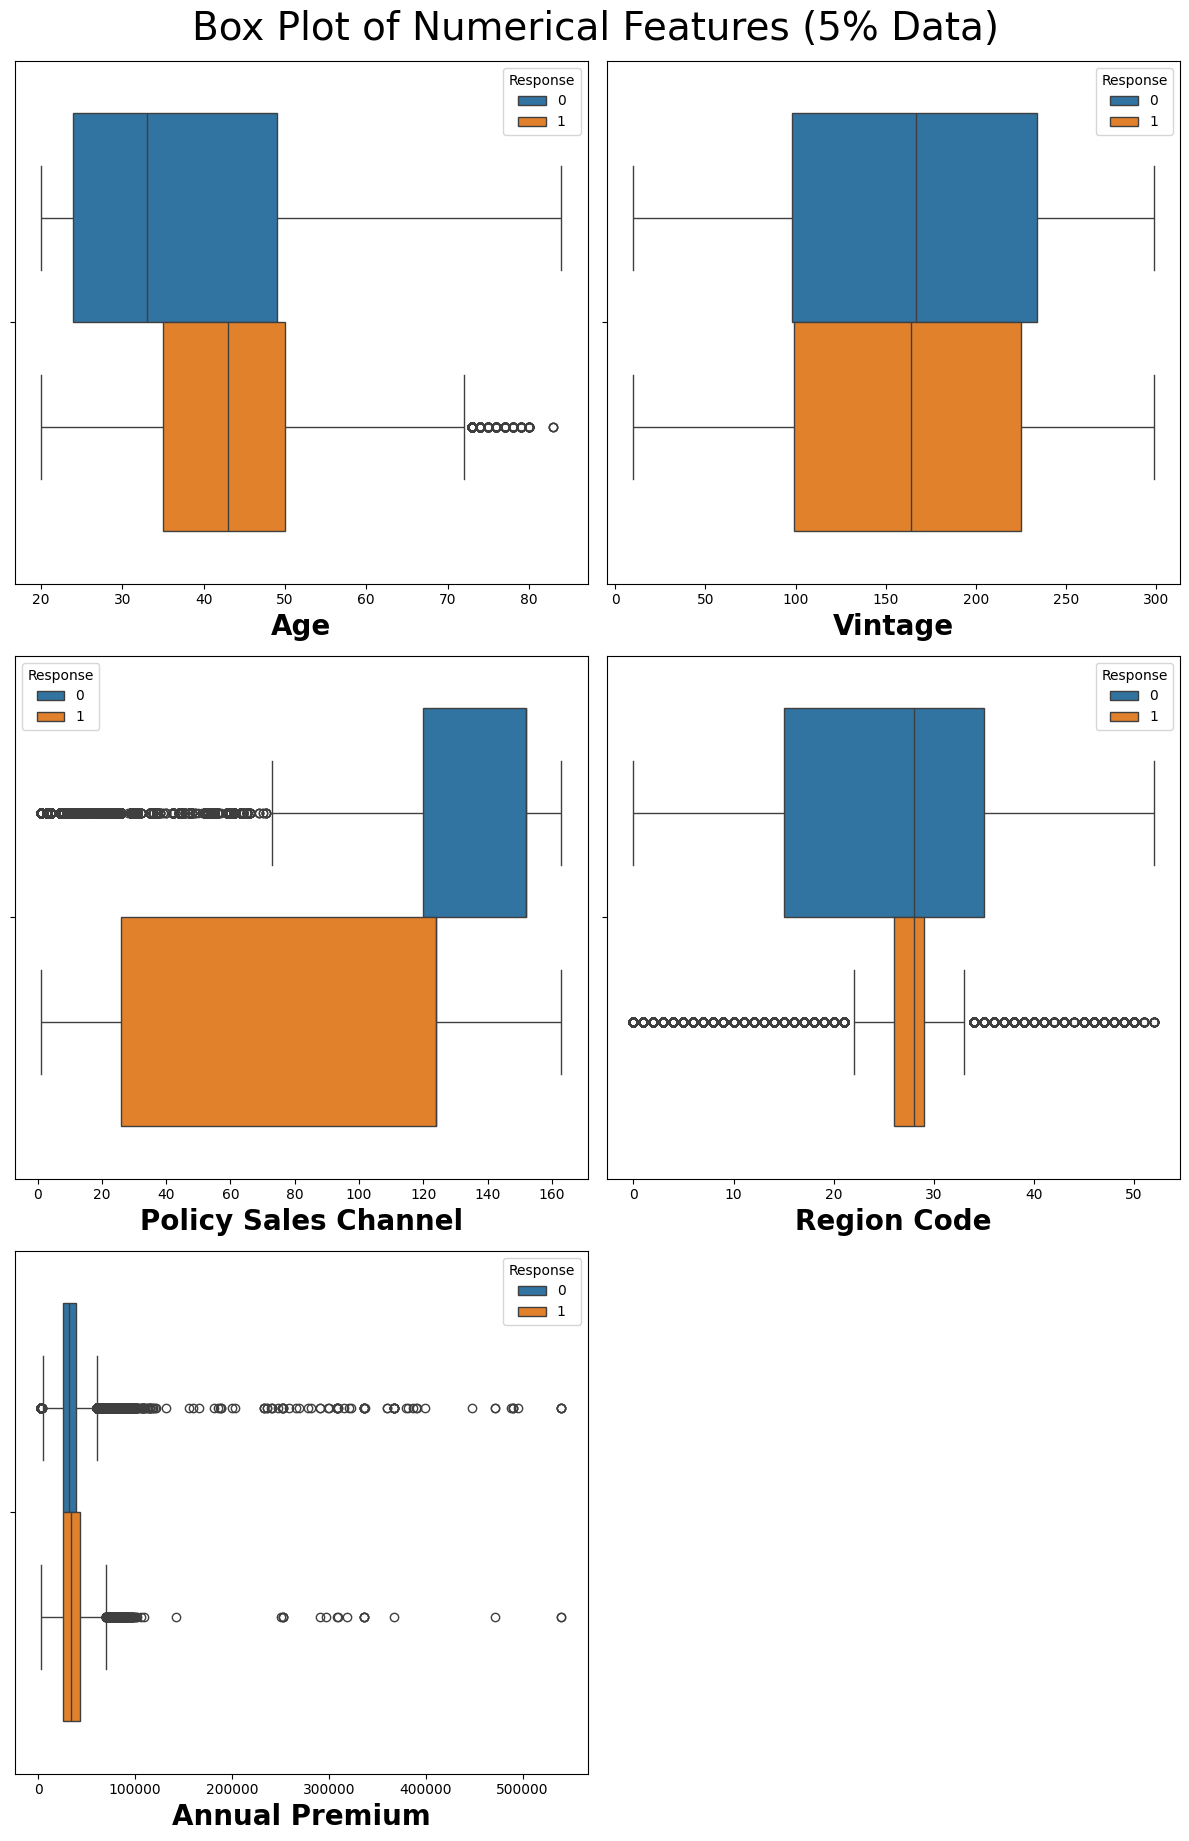

In [20]:
plt.figure(figsize=(12, 18))

for i, col in enumerate(numerical_features):
    plt.subplot(3, 2, i+1)
    sns.boxplot(data=train_sampled, x=col, hue=target)
    plt.xlabel(' '.join(col.split('_')), weight="bold", size=20)
    plt.ylabel("")

plt.tight_layout()
plt.suptitle("Box Plot of Numerical Features (5% Data)", size=28, y=1.02)
plt.show()

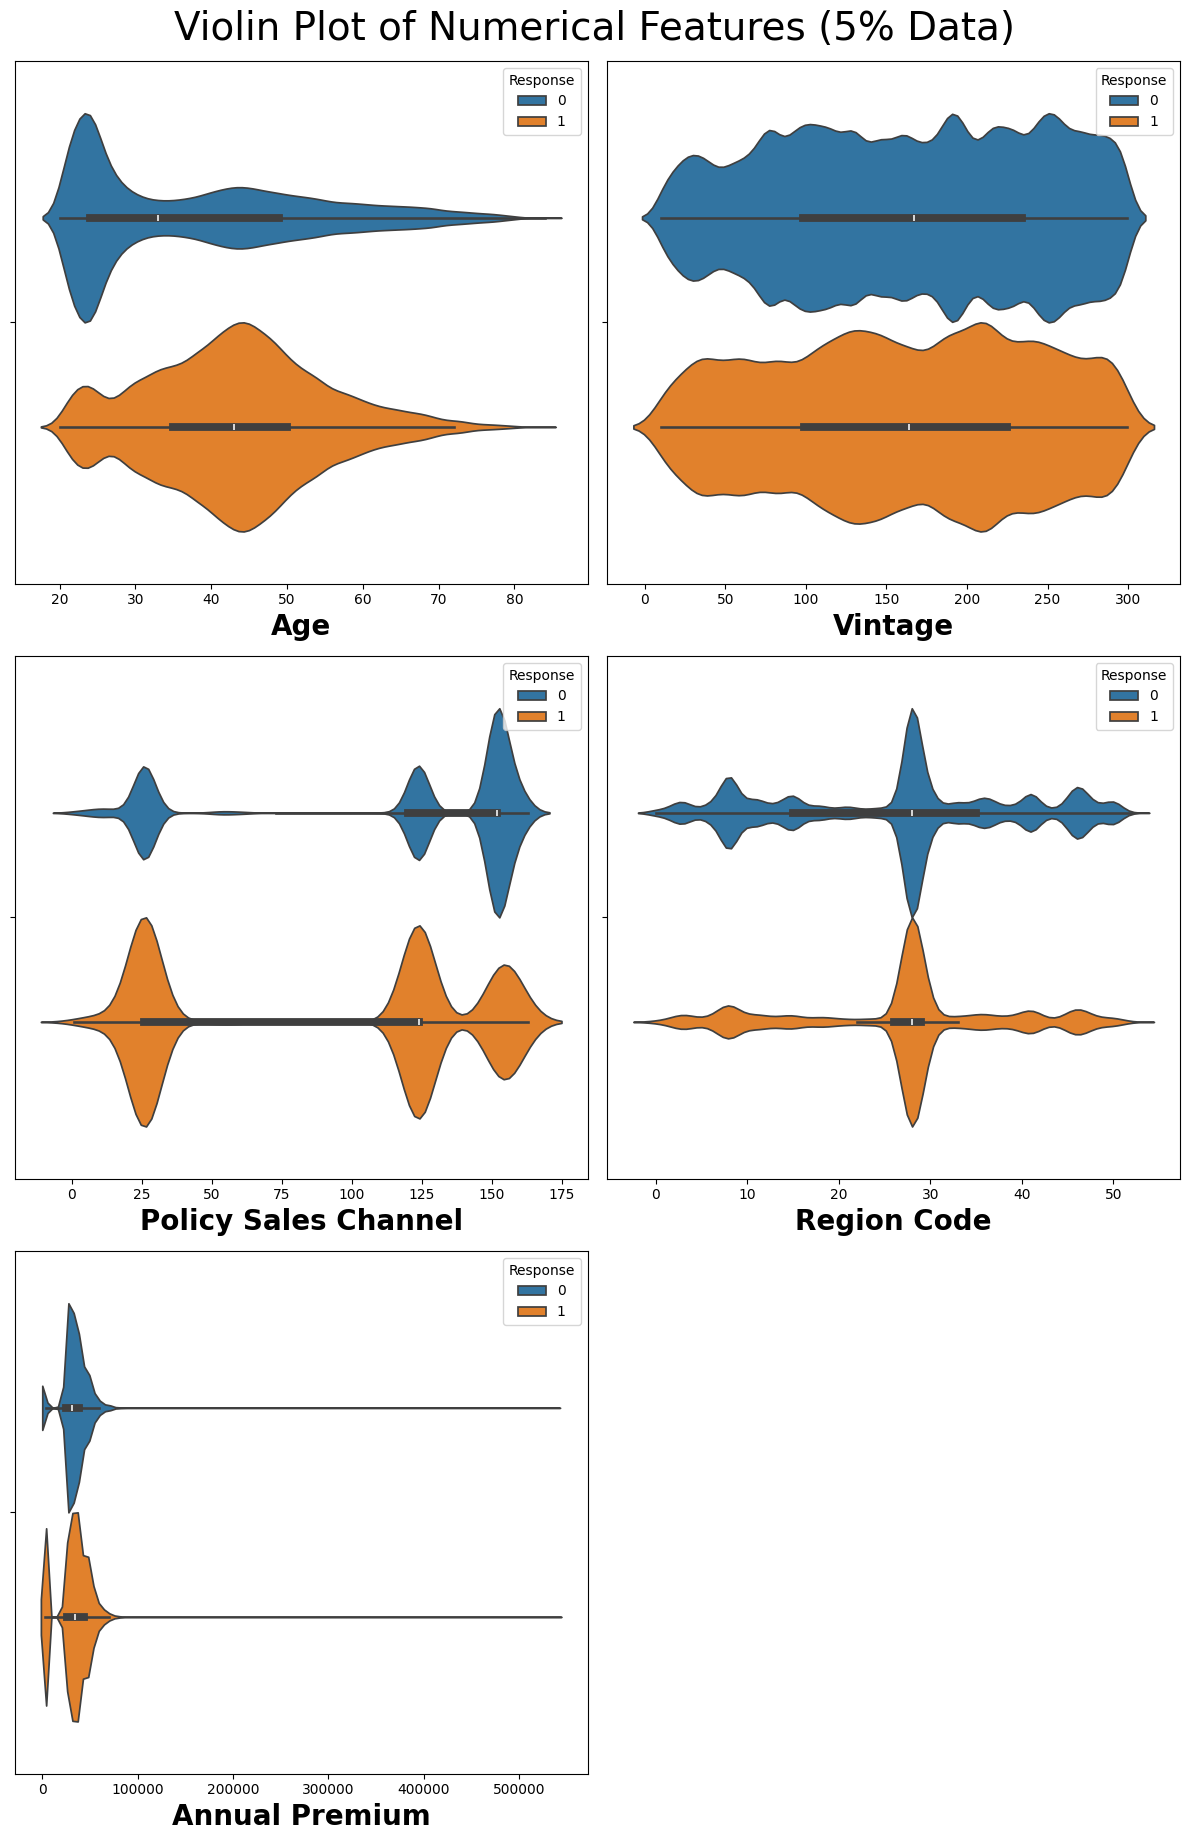

In [21]:
plt.figure(figsize=(12, 18))

for i, col in enumerate(numerical_features):
    plt.subplot(3, 2, i+1)
    sns.violinplot(data=train_sampled, x=col, hue=target)
    plt.xlabel(' '.join(col.split('_')), weight="bold", size=20)
    plt.ylabel("")

plt.tight_layout()
plt.suptitle("Violin Plot of Numerical Features (5% Data)", size=28, y=1.02)
plt.show()

# Correlation

In [22]:
def encoder(df):
    gender_map = {
        'Female': 0,
        'Male': 1
    }

    vehicle_age_map = {
        '< 1 Year': 0,
        '1-2 Year': 1,
        '> 2 Years': 2
    }

    vehicle_damage_map = {
        'No': 0,
        'Yes': 1
    }

    df['Gender'] = df['Gender'].map(gender_map).astype(np.int8)
    df['Driving_License'] = df['Driving_License'].astype(np.int8)
    df['Previously_Insured'] = df['Previously_Insured'].astype(np.int8)
    df['Vehicle_Age'] = df['Vehicle_Age'].map(vehicle_age_map).astype(np.int8)
    df['Vehicle_Damage'] = df['Vehicle_Damage'].map(vehicle_damage_map).astype(np.int8)

    return df

In [23]:
train_copy = train.copy()
train_copy = encoder(train_copy)

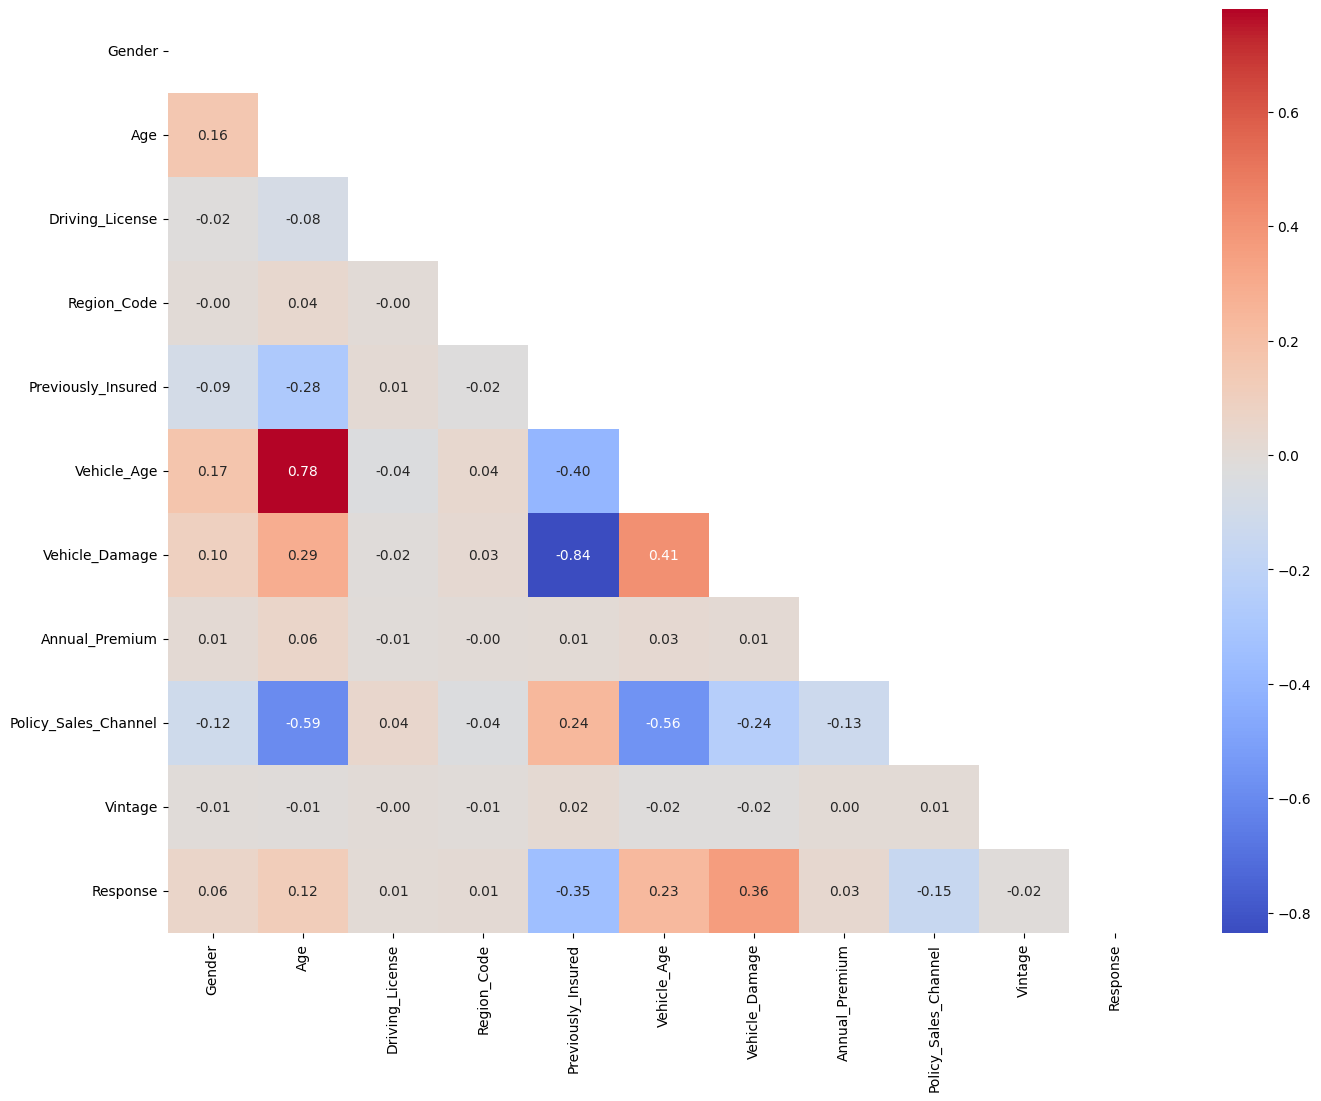

In [24]:
cor_mat = train_copy.corr(method="pearson")
mask = np.triu(np.ones_like(cor_mat))

plt.figure(figsize=(16, 12))
sns.heatmap(cor_mat, cmap='coolwarm', fmt='.2f', annot=True, mask=mask)
plt.show()

# Feature Selection

In [25]:
X_copy = train_copy.sample(frac=0.05)
y_copy = X_copy.pop(target)

mi_scores = mutual_info_classif(X_copy, y_copy, discrete_features=X_copy.dtypes==int, n_neighbors=5, random_state=42)
mi_scores = pd.Series(mi_scores, index=initial_features)
mi_scores = mi_scores.sort_values(ascending=False)

In [26]:
mi_scores

Previously_Insured      0.124334
Vehicle_Damage          0.113345
Policy_Sales_Channel    0.056172
Driving_License         0.054084
Vehicle_Age             0.045621
Gender                  0.041886
Age                     0.035047
Annual_Premium          0.029004
Region_Code             0.018031
Vintage                 0.014008
dtype: float64

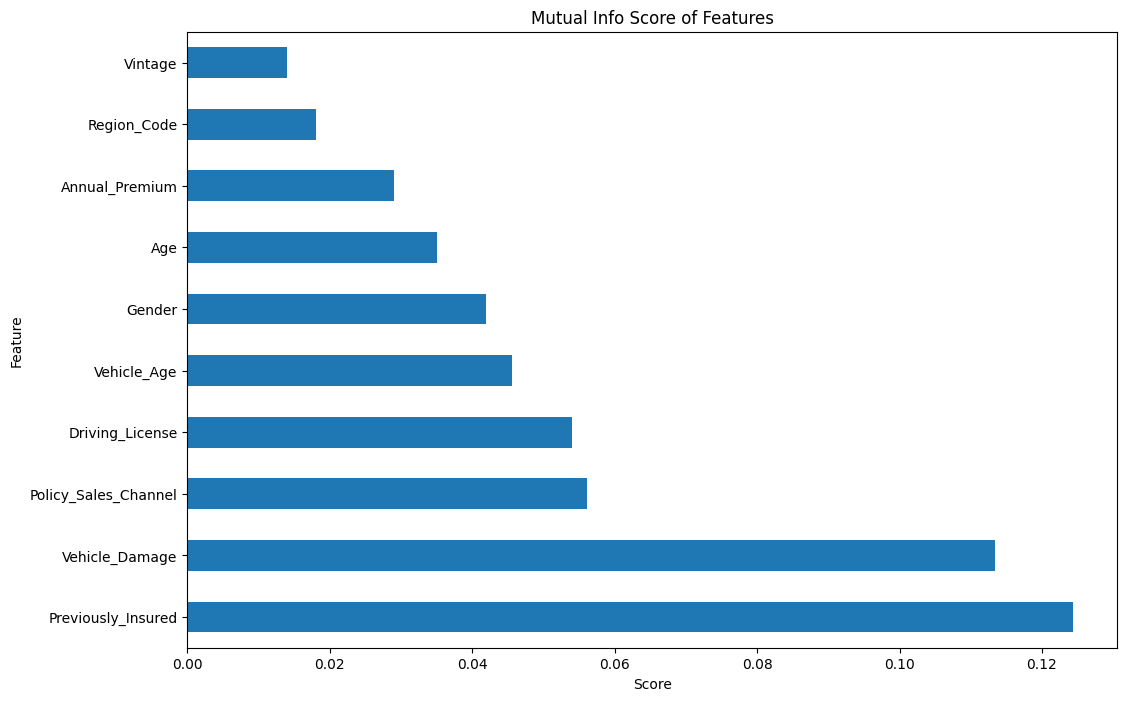

In [27]:
mi_scores.plot(kind='barh', title='Mutual Info Score of Features', figsize=(12, 8), xlabel="Score", ylabel="Feature")
plt.show()

# Model Training

In [9]:
X = train.drop(target, axis=1)
y = train[target]

In [10]:
skfold = StratifiedKFold(5, shuffle=True, random_state=42)

In [11]:
cat_params = {
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'class_names': [0, 1],
    'learning_rate': 0.075,
    'iterations': 3000,
    'depth': 9,
    'random_strength': 0,
    'l2_leaf_reg': 0.5,
    'max_leaves': 512,
    'fold_permutation_block': 64,
    'task_type': 'GPU',
    'random_seed': 42,
    'verbose': False,
    'allow_writing_files': False
}

In [12]:
oof_preds = []
oof_aucs = []

test_pool = cb.Pool(test.astype(str), cat_features=X.columns.values)

for fold, (train_idx, test_idx) in enumerate(skfold.split(X, y)):
    X_train, y_train = X.iloc[train_idx], y[train_idx]
    X_test, y_test = X.iloc[test_idx], y[test_idx]

    X_train_pool = cb.Pool(X_train.astype(str), y_train, cat_features=X.columns.values)
    X_test_pool = cb.Pool(X_test.astype(str), y_test, cat_features=X.columns.values)

    cat_clf = cb.CatBoostClassifier(**cat_params)
    cat_clf = cat_clf.fit(X=X_train_pool,
                          eval_set=X_test_pool,
                          verbose=500,
                          early_stopping_rounds=200)

    test_pred = cat_clf.predict_proba(test_pool)[:, 1]

    oof_preds.append(test_pred)
    auc = cat_clf.best_score_['validation']['AUC']
    oof_aucs.append(auc)
    print(f"\n---- Fold {fold}: ROC-AUC Score: {auc:.6f}\n")

    del X_train, y_train, X_test, y_test
    del X_train_pool, X_test_pool
    del cat_clf
    gc.collect()

auc_mean = np.mean(oof_aucs)
auc_std = np.std(oof_aucs)
print(f"\n---> ROC-AUC Score: {auc_mean:.6f} \xB1 {auc_std:.6f}\n")

test_pred_cat = np.mean(oof_preds, axis=0)

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8750775	best: 0.8750775 (0)	total: 1.02s	remaining: 50m 58s
500:	test: 0.8942961	best: 0.8942961 (500)	total: 6m 19s	remaining: 31m 34s
1000:	test: 0.8946753	best: 0.8946767 (994)	total: 12m 5s	remaining: 24m 7s
1500:	test: 0.8947839	best: 0.8947839 (1500)	total: 17m 47s	remaining: 17m 46s
2000:	test: 0.8948388	best: 0.8948411 (1984)	total: 23m 29s	remaining: 11m 43s
bestTest = 0.8948500156
bestIteration = 2204
Shrink model to first 2205 iterations.

---- Fold 0: ROC-AUC Score: 0.894850



Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8743702	best: 0.8743702 (0)	total: 1.02s	remaining: 51m 4s
500:	test: 0.8937778	best: 0.8937778 (500)	total: 6m 18s	remaining: 31m 26s
1000:	test: 0.8941854	best: 0.8941860 (996)	total: 12m 3s	remaining: 24m 4s
1500:	test: 0.8943081	best: 0.8943081 (1500)	total: 17m 44s	remaining: 17m 42s
2000:	test: 0.8943469	best: 0.8943508 (1900)	total: 23m 30s	remaining: 11m 44s
bestTest = 0.8943674564
bestIteration = 2231
Shrink model to first 2232 iterations.

---- Fold 1: ROC-AUC Score: 0.894367



Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8743713	best: 0.8743713 (0)	total: 1.02s	remaining: 51m 7s
500:	test: 0.8941138	best: 0.8941138 (500)	total: 6m 20s	remaining: 31m 36s
1000:	test: 0.8944996	best: 0.8944996 (1000)	total: 12m 2s	remaining: 24m 3s
1500:	test: 0.8946233	best: 0.8946233 (1500)	total: 17m 44s	remaining: 17m 43s
2000:	test: 0.8946446	best: 0.8946505 (1864)	total: 23m 28s	remaining: 11m 43s
bestTest = 0.8946505189
bestIteration = 1864
Shrink model to first 1865 iterations.

---- Fold 2: ROC-AUC Score: 0.894651



Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8742307	best: 0.8742307 (0)	total: 1.15s	remaining: 57m 21s
500:	test: 0.8939482	best: 0.8939482 (500)	total: 6m 20s	remaining: 31m 39s
1000:	test: 0.8943265	best: 0.8943265 (1000)	total: 12m 6s	remaining: 24m 11s
1500:	test: 0.8944525	best: 0.8944528 (1489)	total: 17m 47s	remaining: 17m 46s
2000:	test: 0.8944971	best: 0.8945013 (1979)	total: 23m 28s	remaining: 11m 43s
bestTest = 0.8945012987
bestIteration = 1979
Shrink model to first 1980 iterations.

---- Fold 3: ROC-AUC Score: 0.894501



Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8748047	best: 0.8748047 (0)	total: 1.02s	remaining: 51m 5s
500:	test: 0.8945994	best: 0.8945994 (500)	total: 6m 18s	remaining: 31m 29s
1000:	test: 0.8950114	best: 0.8950114 (999)	total: 12m 4s	remaining: 24m 7s
1500:	test: 0.8951205	best: 0.8951206 (1497)	total: 17m 46s	remaining: 17m 44s
2000:	test: 0.8951572	best: 0.8951582 (1997)	total: 23m 24s	remaining: 11m 41s
bestTest = 0.8951630592
bestIteration = 2272
Shrink model to first 2273 iterations.

---- Fold 4: ROC-AUC Score: 0.895163


---> ROC-AUC Score: 0.894706 ± 0.000279



# Submission

In [13]:
sub = pd.DataFrame({
    'id': test.index,
    'Response': test_pred_cat
})

sub.to_csv('/content/drive/MyDrive/Colab Notebooks/kaggle/insurance_selling/submission_240718_1.csv', index=False)
sub

,id,Response
0,11504798,0.006027
1,11504799,0.649252
2,11504800,0.246978
3,11504801,0.000060
4,11504802,0.240916
...,...,...
7669861,19174659,0.188530
7669862,19174660,0.000112
7669863,19174661,0.000189
7669864,19174662,0.591798
